<a href="https://colab.research.google.com/github/Saadman53/Thesis-Human-Action-Recognition/blob/main/cnn_on_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
from google.colab import drive
drive.mount('/content/drive')
gdrive_path = "drive/My Drive/Dataset/cutu.mat"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [166]:
!pip install minepy
!pip install sklearn_relief
!pip install sklearn-genetic
!pip install info_gain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from minepy import MINE
from sklearn.feature_selection import mutual_info_regression
import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from scipy.special import entr
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import differential_entropy
from scipy.stats import entropy

from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from genetic_selection import GeneticSelectionCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import mutual_info_regression
from info_gain import info_gain

import random
from sklearn.metrics import confusion_matrix, recall_score, precision_score


import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report


from torch.utils.data import DataLoader, ConcatDataset
# from torchvision import transforms
from sklearn.model_selection  import StratifiedKFold
%matplotlib inline

import scipy.io as sio

In [168]:
dat = sio.loadmat(gdrive_path)
train_x = dat['train_X']
train_y = dat['train_y'][0]-1
test_x = dat['test_X']
test_y = dat['test_y'][0]-1

In [169]:
X = np.concatenate((train_x,test_x),axis = 0)
y = np.concatenate((train_y,test_y),axis = 0)

In [170]:
conv1 = nn.Conv2d(1,6,5)
pool = F.avg_pool2d
conv2 = nn.Conv2d(6,16,5)

In [171]:
x = torch.from_numpy(X[0].astype(np.float32))

x.shape

torch.Size([1, 64, 64])

In [172]:
x1 = conv1(x)
x1.shape

torch.Size([6, 60, 60])

In [173]:
x1 = pool(x1,2,2)
x1.shape

torch.Size([6, 30, 30])

In [174]:

x1 = conv2(x1)
x1.shape

torch.Size([16, 26, 26])

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42, stratify = y)

In [176]:
X_train[0].ravel().shape

(4096,)

In [177]:
class CNN(nn.Module):
    def __init__(self,output_size):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.max_pool = nn.MaxPool2d(2,2)
        self.avg_pool = F.avg_pool2d
        self.conv2 = nn.Conv2d(6,16,5)
        # self.hidden1 = nn.Linear(16*6*6,2048)
        # self.hidden2 = nn.Linear(2048,1024)
        # self.hidden3 = nn.Linear(1024,512)
        self.hidden3 = nn.Linear(16*6*6,512)
        self.hidden4 = nn.Linear(512,256)
        self.hidden5 = nn.Linear(256,128)
        self.hidden6 = nn.Linear(128,64)
        self.output = nn.Linear(64,output_size)
        self.softmax = F.softmax
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.batchnorm1 = nn.BatchNorm1d(2048)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.batchnorm3 = nn.BatchNorm1d(512)
        self.batchnorm4 = nn.BatchNorm1d(256)
        self.batchnorm5 = nn.BatchNorm1d(128)
        self.batchnorm6 = nn.BatchNorm1d(64)
    
    def forward(self,x):
        out = self.max_pool(self.relu(self.conv1(x)))
        out = self.max_pool(self.relu(self.conv2(out)))
        #print(out.shape)
        out = self.avg_pool(out, 2,2)
        #print(out.shape)
        out = out.view(-1, 16*6*6)
        # out = self.hidden1(out)
        # out = self.batchnorm1(out)
        # out = self.relu(out)
        
        # out = self.hidden2(out)
        # out = self.batchnorm2(out)
        # out = self.relu(out)
        # out = self.dropout(out)

        out = self.hidden3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.hidden4(out)
        out = self.batchnorm4(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.hidden5(out)
        out = self.batchnorm5(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.hidden6(out)
        out = self.batchnorm6(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.output(out)
        return out

In [178]:
def extract_batch(X,y,batch_size,step,no_of_samples):
  l = (step-1)*batch_size
  return X[l:(l+batch_size)],y[l:min(no_of_samples,l+batch_size)]
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)   
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum()*1.0 / len(correct_pred)
    acc = acc * 100
    return acc

In [179]:
def plot_confusion_matrix(net, test_X, test_y):
  y_pred = net(test_X)
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred = torch.max(y_pred_softmax, dim = 1)   
  y_pred = y_pred.detach().numpy().ravel()
  cm = confusion_matrix(test_y.ravel(), y_pred)
  #tn, fp, fn, tp = cm.ravel()
  recall = np.mean(recall_score(test_y.ravel(), y_pred, average=None))*100.0
  precision = np.mean(precision_score(test_y.ravel(), y_pred, average=None))*100.0
  f,ax=plt.subplots(figsize=(20,10))
  sns.heatmap(cm,annot=True,fmt='.0f', cmap="Blues")
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()
  return cm, y_pred,recall, precision

In [180]:
def model_training_evaluation(X_train, X_test, y_train, y_test):
  train_X = torch.from_numpy(X_train.astype(np.float32))
  test_X = torch.from_numpy(X_test.astype(np.float32))
  train_y =  torch.tensor(y_train)
  test_y =  torch.tensor(y_test)
  output_size = torch.unique(train_y).shape[0]
  num_epochs = 101
  n_samples = train_X.shape[0]
  criterion = nn.CrossEntropyLoss(reduction='sum')
  best_lr = None
  best_loss = 100000
  best_model = None
  best_train_loss = None
  best_val_loss = None
  best_epoch = None
  skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
  for lr in [0.03]:
    #print(f"Learning rate: {lr}:")
    net = CNN( output_size)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)  
    cnt = 1
    figure, ax = plt.subplots(3,figsize=(12,8))
    figure.tight_layout()
    for train_index, val_index in skf.split(X_train, y_train):
      train_X_fold = train_X[train_index]
      train_y_fold = train_y[train_index]
      val_x_fold = train_X[val_index]
      val_y_fold = train_y[val_index]
      n_samples = train_X_fold.shape[0]
      batch_size = int(n_samples/5)
      train_loss = []
      val_loss = []
      print(f"Training for fold {cnt}")
      for epoch in range(num_epochs):
        step = 1
        while(batch_size*step<=n_samples):
          x,y =  extract_batch(train_X_fold,train_y_fold, batch_size, step, n_samples)
          # Forward Propagation
          y_predicted = net(x)
          #print(batch_size,y_predicted.shape, y.shape)
          loss = criterion(y_predicted,  torch.tensor(y, dtype=torch.long))
          # Backward propagation and update
          loss.backward()
          optimizer.step()
          # Performing zero grad before new step
          optimizer.zero_grad()
          step = step+1
        t_loss = criterion( net(train_X_fold),  torch.tensor(train_y_fold, dtype=torch.long)).item()/train_X_fold.shape[0]
        v_loss = criterion( net(val_x_fold),  torch.tensor(val_y_fold, dtype=torch.long)).item()/val_x_fold.shape[0]
        train_loss.append(t_loss) 
        val_loss.append(v_loss)
        print(f"Epoch {epoch+1} completed.")
        if(v_loss<best_loss):
          best_lr = lr
          best_loss = v_loss
          best_model = net
          best_epoch = epoch
      m = "Fold "+str(cnt)
      ax[cnt-1].title.set_text(m)
      ax[cnt-1].set_ylabel("Total Loss")
      ax[cnt-1].set_xlabel("No of Epochs")
      ax[cnt-1].plot(range(num_epochs),train_loss, label = "train loss")
      ax[cnt-1].plot(range(num_epochs),val_loss, label = "validation loss")
      cnt+=1
  y_pred = best_model(test_X)
  acc = multi_acc(y_pred, test_y)
  cm, pred,recall, precision = plot_confusion_matrix(best_model, test_X, y_test)
  print(f"Accuracy is {(acc):.2f}%")
  print(f"Recall is {(recall):.2f}%")
  print(f"Precision is {(precision):.2f}%")


Training for fold 1
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
Epoch 6 completed.
Epoch 7 completed.
Epoch 8 completed.
Epoch 9 completed.
Epoch 10 completed.
Epoch 11 completed.
Epoch 12 completed.
Epoch 13 completed.
Epoch 14 completed.
Epoch 15 completed.
Epoch 16 completed.
Epoch 17 completed.
Epoch 18 completed.
Epoch 19 completed.
Epoch 20 completed.
Epoch 21 completed.
Epoch 22 completed.
Epoch 23 completed.
Epoch 24 completed.
Epoch 25 completed.
Epoch 26 completed.
Epoch 27 completed.
Epoch 28 completed.
Epoch 29 completed.
Epoch 30 completed.
Epoch 31 completed.
Epoch 32 completed.
Epoch 33 completed.
Epoch 34 completed.
Epoch 35 completed.
Epoch 36 completed.
Epoch 37 completed.
Epoch 38 completed.
Epoch 39 completed.
Epoch 40 completed.
Epoch 41 completed.
Epoch 42 completed.
Epoch 43 completed.
Epoch 44 completed.
Epoch 45 completed.
Epoch 46 completed.
Epoch 47 completed.
Epoch 48 completed.
Epoch 49 completed.
Epoch 50 

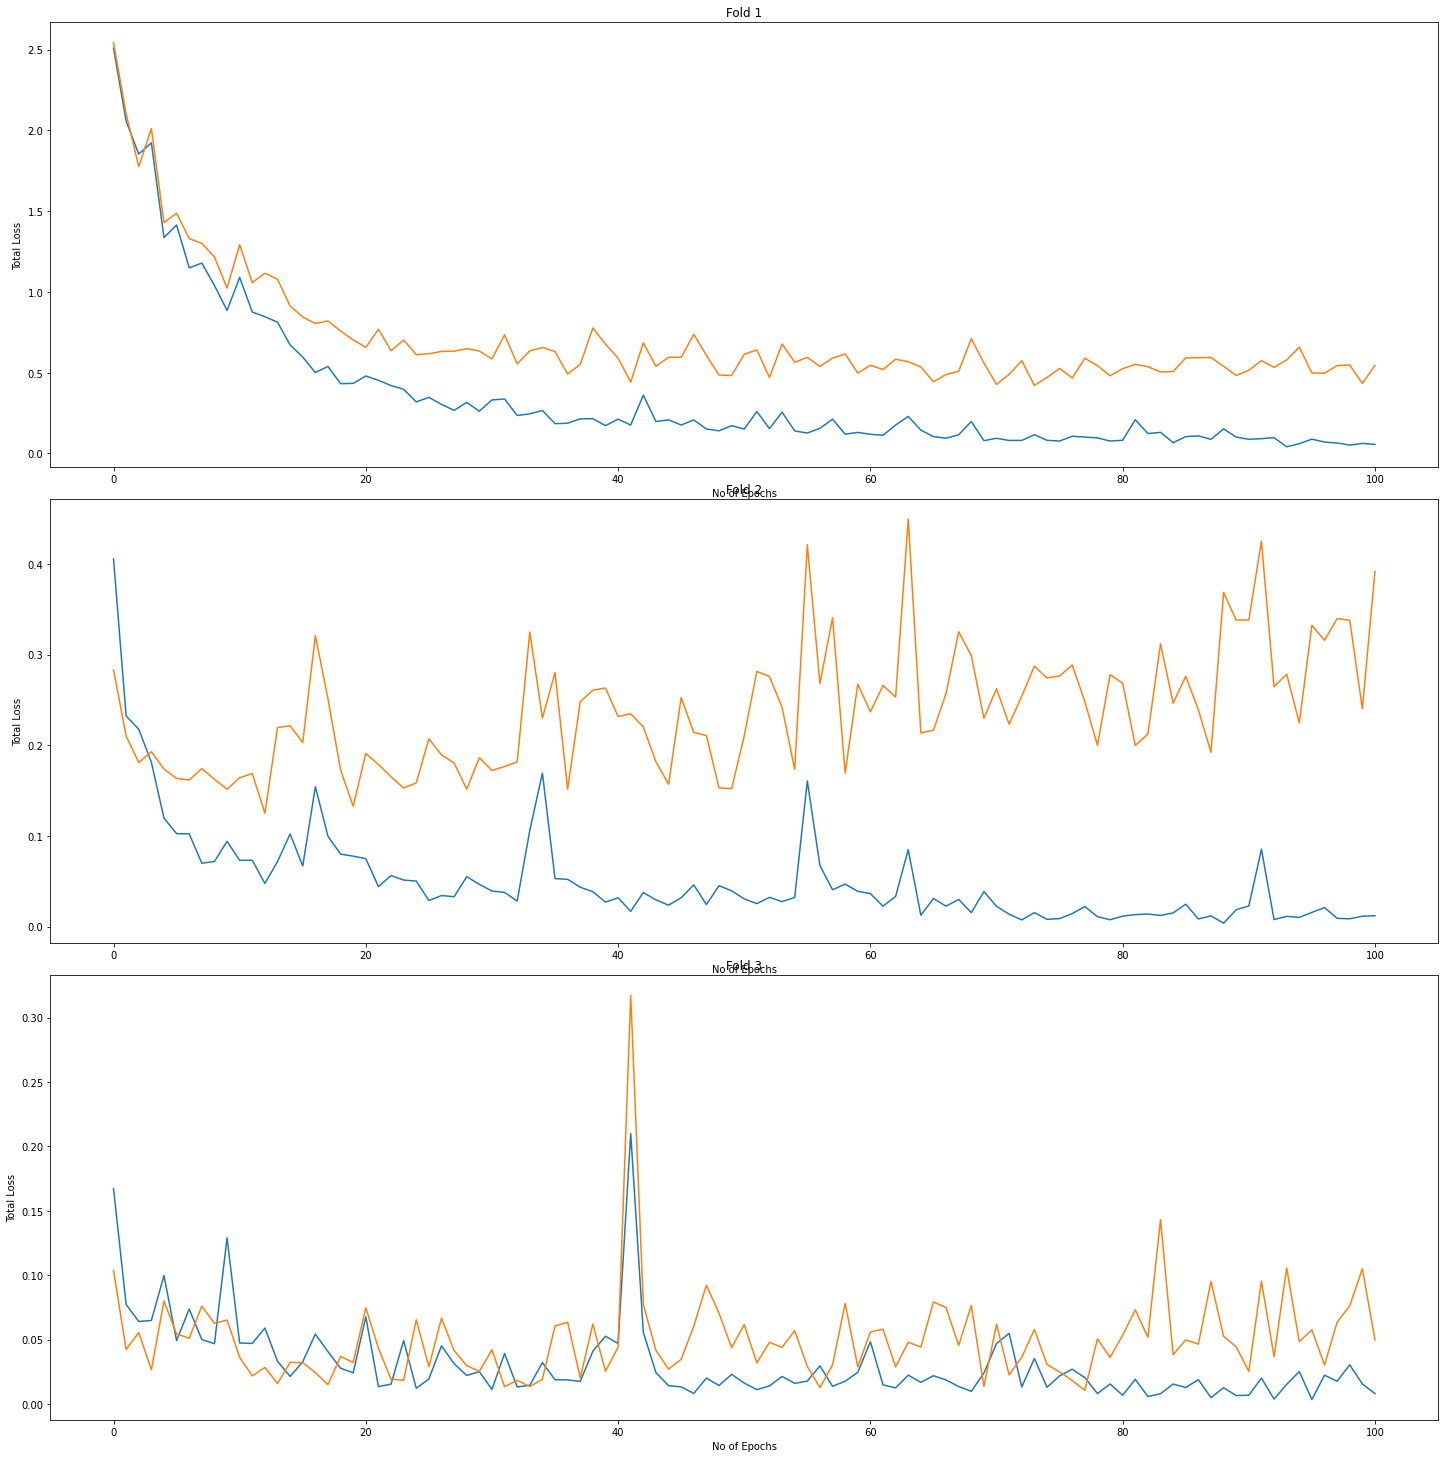

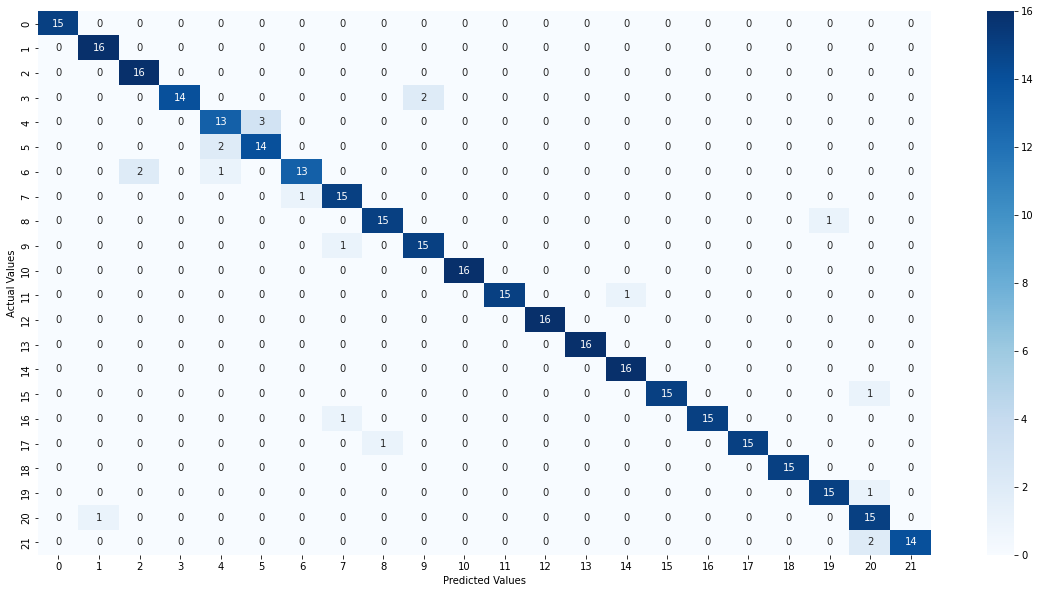

Accuracy is 94.29%
Recall is 94.03%
Precision is 94.39%


In [181]:
model_training_evaluation(X_train, X_test, y_train, y_test)